In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from skimage import measure
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import numpy as np

# Load in a single timestep of 3D data from SAM

In [3]:
data = xr.open_dataset("../data/SAM_3D_snapshot.nc")
data

<xarray.Dataset>
Dimensions:  (x: 100, y: 100, z: 64)
Coordinates:
  * z        (z) float32 25.0 75.0 127.848 ... 24903.123 25893.436 26982.78
  * x        (x) float64 0.0 101.0 202.0 303.0 ... 9.798e+03 9.899e+03 1e+04
  * y        (y) float64 0.0 101.0 202.0 303.0 ... 9.798e+03 9.899e+03 1e+04
Data variables:
    p        (z) float32 ...
    TABS     (z, y, x) float32 ...
    QP       (z, y, x) float32 ...
    QR       (z, y, x) float32 ...
    QN       (z, y, x) float32 ...

CPU times: user 1.87 s, sys: 28.7 ms, total: 1.9 s
Wall time: 1.86 s


Text(0.5, 0.92, 'Isosurfaces: 0.1 g m$^{-2}$ total condensate')

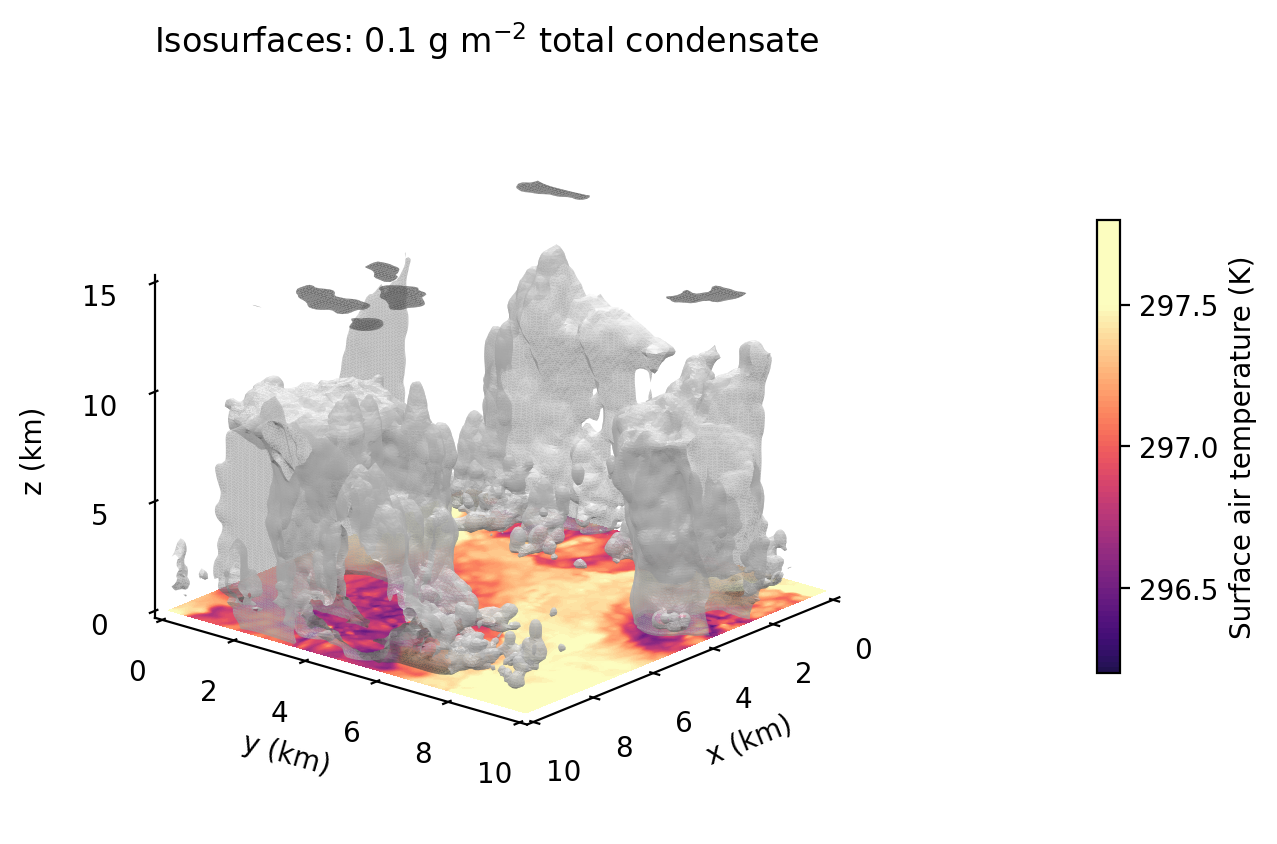

In [15]:
%%time

sun = LightSource(azdeg = -10, altdeg = 90)

fig, ax = plt.subplots(figsize = (15, 5), dpi = 200, subplot_kw={'projection':'3d'})

ax.view_init(elev = 20, azim = 40)
ax.set_proj_type('ortho')
ax.margins(0)
ax.grid(False)
ax.set_zticks([0, 5, 10, 15])
ax.set_zlabel('z (km)')
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.spines['left'].set_visible(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Set up plot
data['x'] = np.linspace(0,10,100)*1e3
data['y'] = np.linspace(0,10,100)*1e3
# Plot temperature on bottom surface
x = data['x'].values
y = data['y'].values

tabs = data['TABS'].isel(z = 0).values
p = ax.contourf(x/1e3, y/1e3, tabs, 100, vmin=296, vmax=297.5, zdir = 'z', offset = 0, cmap = 'magma')
fig.colorbar(p, ax = ax, label = 'Surface air temperature (K)', 
             ticks=[296.5, 297, 297.5], shrink = 0.6, pad = 0.1)

ax.axes.set_zlim3d(bottom = 0, top = 15)

# Calculate total condensate
rgas = 287.0 # specific gas constant for dry air
rho = data['p']*1e2/(rgas*data['TABS'])
qcloud = ((data['QN'] + data['QP'])*rho).values


""" Regrid the data to a uniform vertical grid """
# New uniform grid
z = 1e3*np.linspace(0.05, 15.0, 128)
dz = z[1] - z[0]

# Raw grid
z0 = data['z'].values
f = interp1d(z0, qcloud, axis = 0)
qcloud = f(z)

# Regrid
qcloud = gaussian_filter(qcloud, sigma = 0.8, mode = 'wrap')

# Decide on condensate threshold and then
# use skimage to extract the corresponding 2D surface mesh
condensate_threshold = 0.1
verts, faces, _, _ = measure.marching_cubes(qcloud, condensate_threshold, spacing = (dz/1e3, 0.1, 0.1))

# Plot unstructured (triangular) mesh
ax.plot_trisurf(verts[:,2], verts[:,1], faces[:], verts[:,0],
            linewidth = 0.0, antialiased = True, color = 'white', alpha = 0.8, 
            shade = True, lightsource = sun)

# Add text
ax.set_title(f'Isosurfaces: {condensate_threshold} g m$^{{-2}}$ total condensate')
